# Machine Learning Models
This notebook includes the following machine learning models for comparison:
- Random Forest
- SVM

## **Prepare Environment**

<br/>

### Imports

In [1]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Other
from IPython.display import Image
import warnings
import pprint
import datetime
import os

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
    show_result_model,
)

<br/>

### Prepare Principal Directory

In [2]:
path_to_work('notebooks')

'Changed directory to: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data/notebooks'

<br/>

### Set Config

In [3]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [5]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [7]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        parse_dates=True,
                        index_col=0,
                        verbose=True)
df_vale3.info()

Tokenization took: 2.27 ms
Type conversion took: 2.28 ms
Parser memory cleanup took: 0.01 ms
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2445 entries, 2010-07-12 to 2020-05-28
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco         2445 non-null   float64
 1   residuos      2445 non-null   float64
 2   tendencia     2445 non-null   float64
 3   sazonalidade  2445 non-null   float64
 4   diff_1        2445 non-null   float64
 5   diff_2        2445 non-null   float64
 6   diff_3        2445 non-null   float64
 7   diff_4        2445 non-null   float64
 8   diff_5        2445 non-null   float64
dtypes: float64(9)
memory usage: 191.0 KB
CPU times: user 15.9 ms, sys: 4.63 ms, total: 20.5 ms
Wall time: 18.8 ms


## Split Data

In [8]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(df_train.columns)
print(df_test.columns)

2132
313
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')


In [9]:
df_vale3_without_target = df_train.columns
df_vale3_without_target = df_vale3_without_target.drop('preco')

print(df_vale3_without_target)

Index(['residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2', 'diff_3',
       'diff_4', 'diff_5'],
      dtype='object')


Text(0.5, 1.0, 'Train size: 2132')

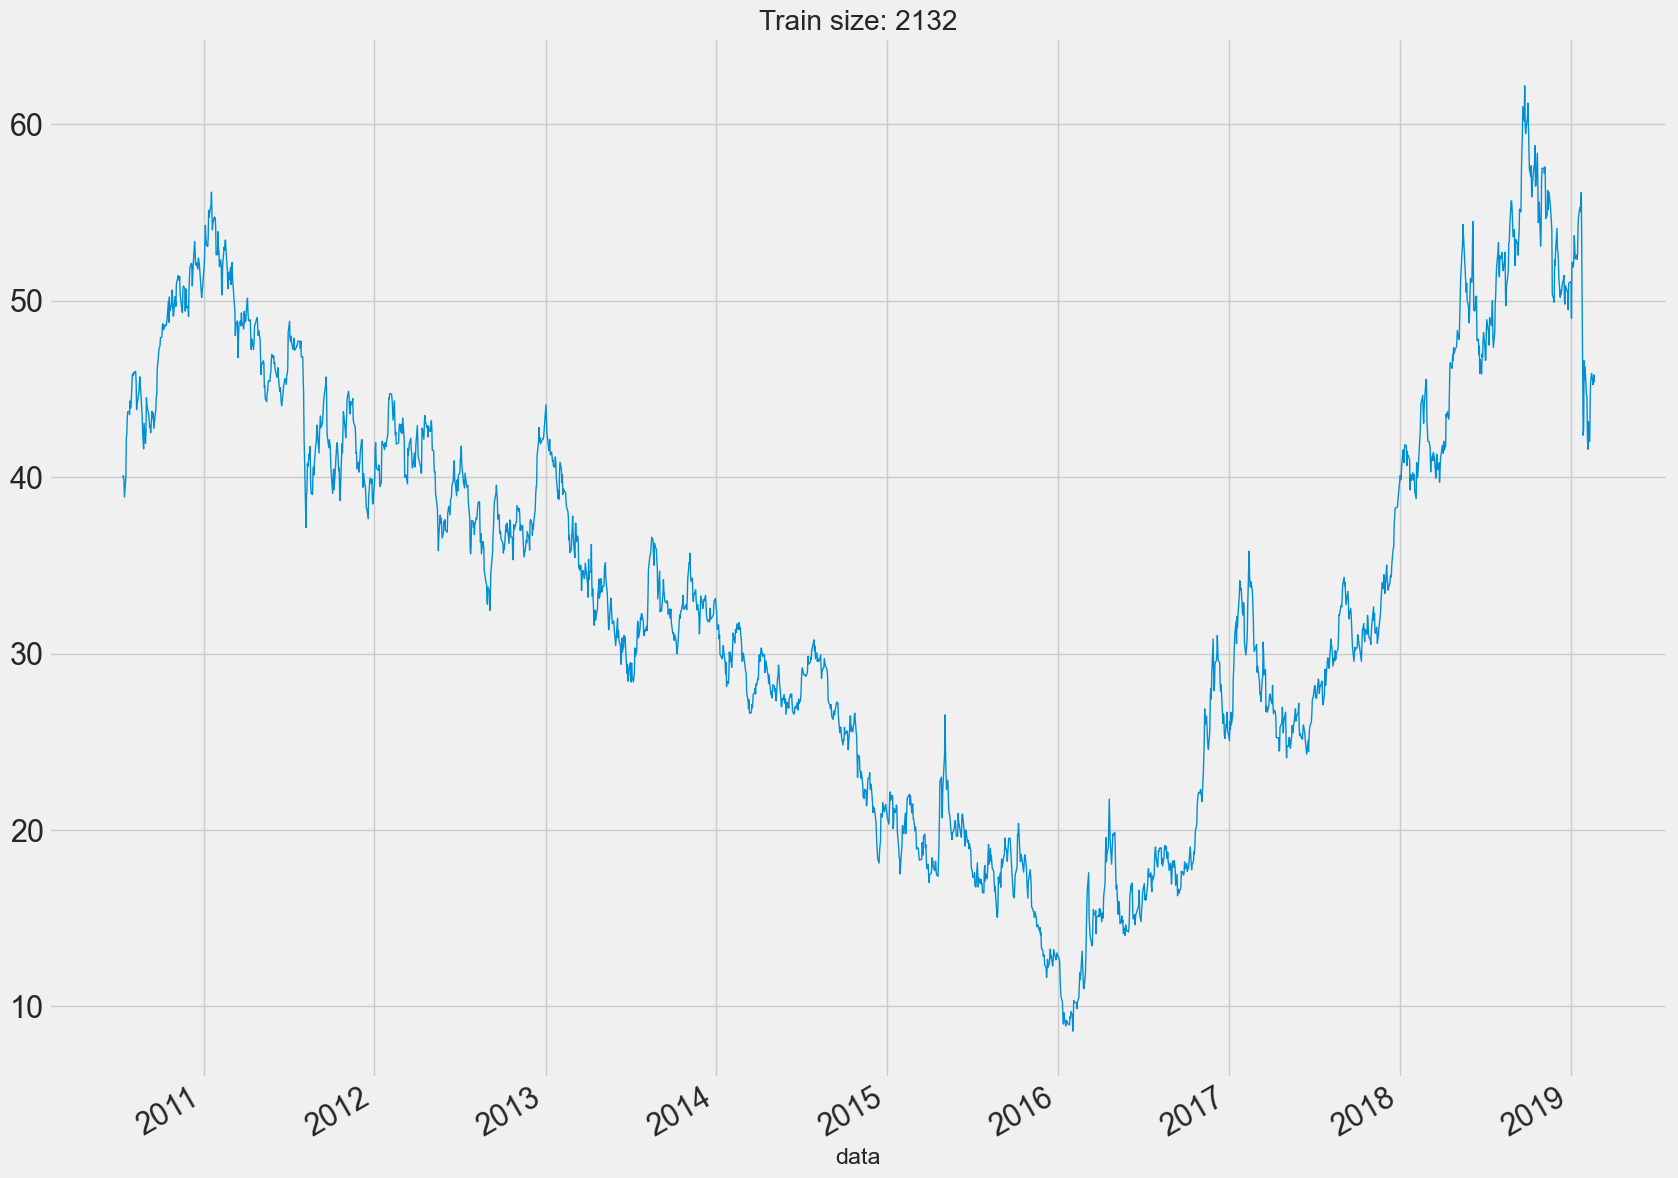

In [10]:
df_train['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 313')

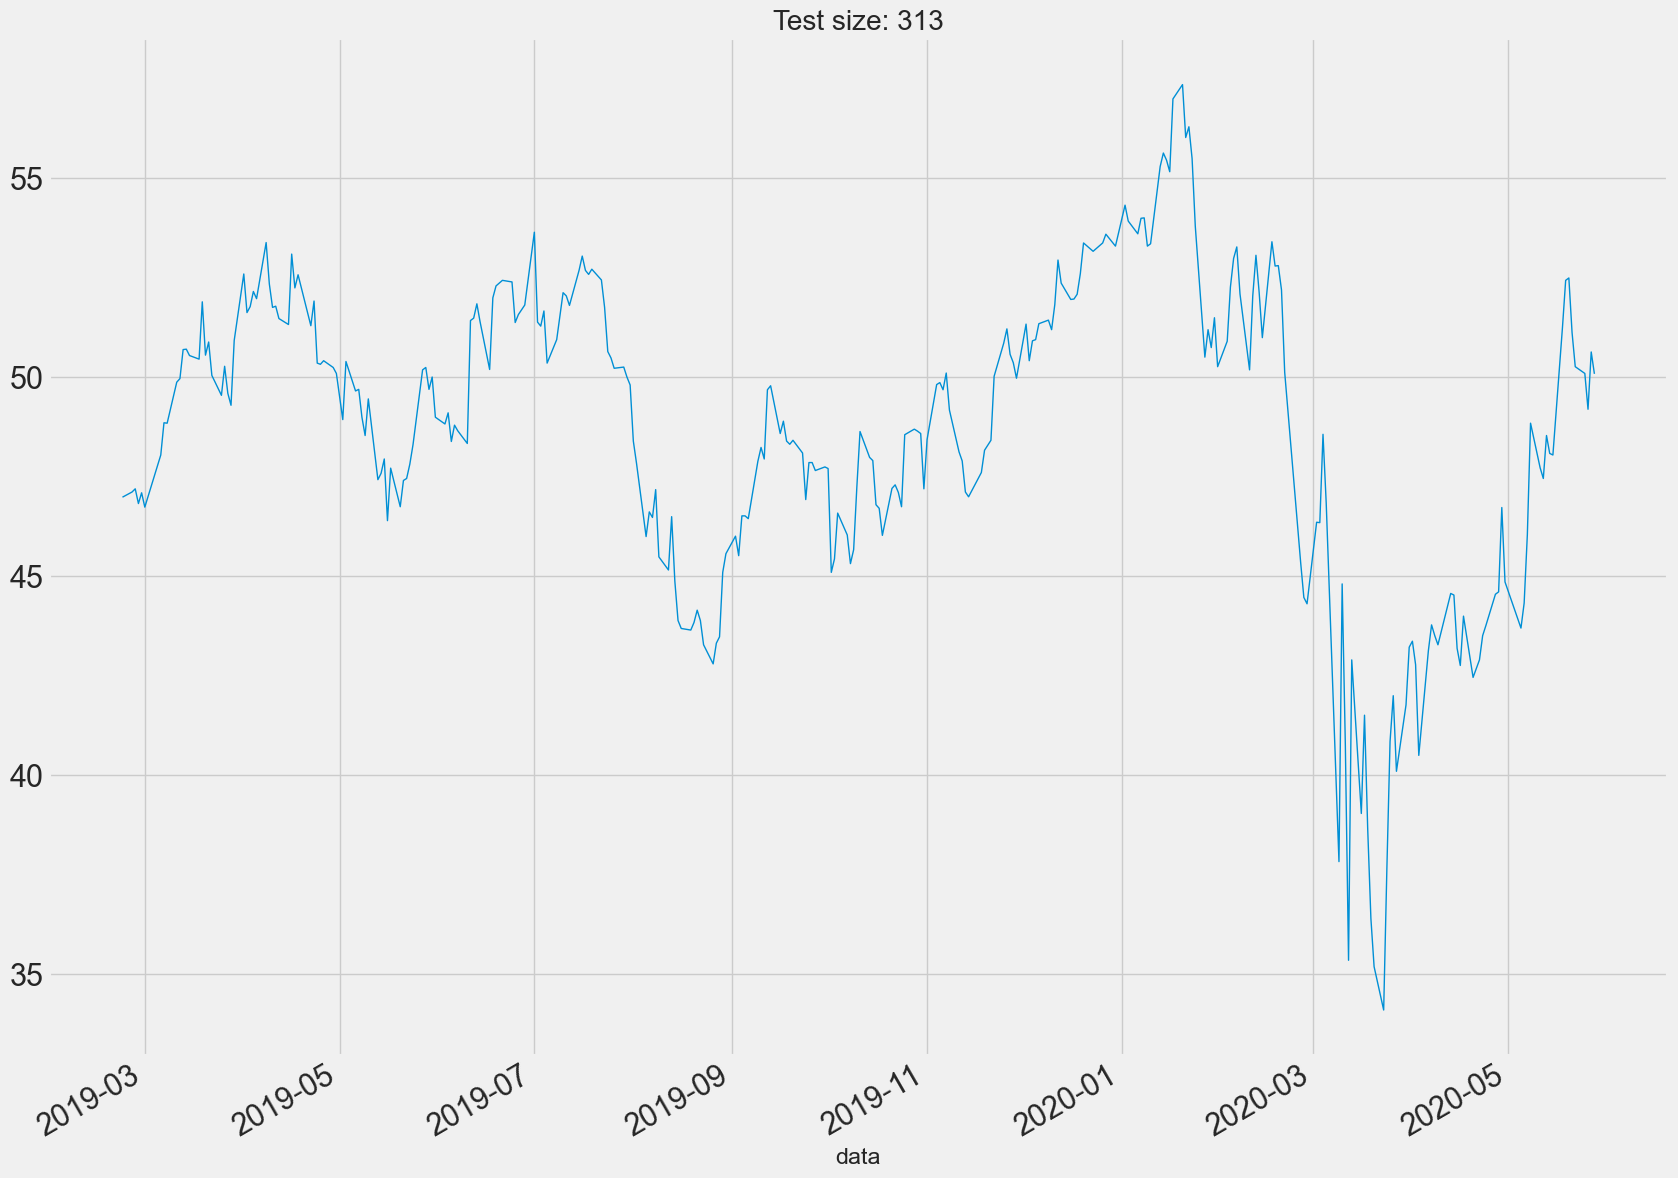

In [11]:
df_test['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [12]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)

In [13]:
df_test.index

DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', length=313, freq=None)

In [14]:
X_train = df_train[df_vale3_without_target]
y_train = df_train['preco']
print(len(X_train))
print(len(y_train))
print(type(X_train))
print(type(y_train))
print((X_train[:5]))
print(y_train[:5])


X_train = df_train[df_vale3_without_target]
y_train = df_train['preco']

2132
2132
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuos  tendencia  sazonalidade  diff_1  diff_2  diff_3  diff_4  \
data                                                                            
2010-07-12      1.00      41.83          1.00   -0.60   -0.46    0.49    0.98   
2010-07-13      1.04      41.91          1.00    0.07   -0.53   -0.39    0.56   
2010-07-14      1.03      41.98          1.00    0.01    0.08   -0.52   -0.38   
2010-07-15      1.04      42.05          1.00   -0.32   -0.31   -0.24   -0.84   
2010-07-16      1.03      42.12          1.00   -0.88   -1.20   -1.19   -1.12   

            diff_5  
data                
2010-07-12    0.42  
2010-07-13    1.05  
2010-07-14    0.57  
2010-07-15   -0.70  
2010-07-16   -1.72  
data
2010-07-12   40.00
2010-07-13   40.07
2010-07-14   40.08
2010-07-15   39.76
2010-07-16   38.88
Name: preco, dtype: float64


In [15]:
X_test = df_test[df_vale3_without_target]
y_test = df_test['preco']
print(len(X_test))
print(len(y_test))
print(type(X_test))
print(type(y_test))
print(X_test[:5])
print(y_test[:5])

313
313
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuos  tendencia  sazonalidade  diff_1  diff_2  diff_3  diff_4  \
data                                                                            
2019-02-22      0.96      46.70          1.00    1.61    1.19    1.50    1.74   
2019-02-25      0.93      46.89          1.00    0.13    1.74    1.32    1.63   
2019-02-26      0.94      47.09          1.00    0.08    0.21    1.82    1.40   
2019-02-27      0.89      47.32          1.00   -0.37   -0.29   -0.16    1.45   
2019-02-28      0.88      47.58          1.00    0.27   -0.10   -0.02    0.11   

            diff_5  
data                
2019-02-22    1.11  
2019-02-25    1.87  
2019-02-26    1.71  
2019-02-27    1.03  
2019-02-28    1.72  
data
2019-02-22   46.99
2019-02-25   47.12
2019-02-26   47.20
2019-02-27   46.83
2019-02-28   47.10
Name: preco, dtype: float64


---

---

## **Evaluation**

In [16]:
dict_results = {}

## Modeling

<br/>

### **Build Model**

#### **Random Forest**

In [30]:
# RandomForest params dict
rf_params_one = {}
rf_params_one['criterion'] = 'absolute_error'
rf_params_one['n_estimators'] = 10
rf_params_one['max_depth'] = 10
rf_params_one['max_features'] = None
rf_params_one['max_leaf_nodes'] = 30
rf_params_one['min_samples_leaf'] = 1
rf_params_one['random_state'] = 0
rf_params_one['n_jobs'] = -1 # run all process

In [31]:
model_rf_regressor = RandomForestRegressor(**rf_params_one)
model_rf_regressor

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=None, max_leaf_nodes=30, n_estimators=10,
                      n_jobs=-1, random_state=0)

In [32]:
model_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=None, max_leaf_nodes=30, n_estimators=10,
                      n_jobs=-1, random_state=0)

In [33]:
y_pred_rf_regressor = model_rf_regressor.predict(X_test)
y_pred_rf_regressor[:5]

array([46.5835, 47.382 , 47.614 , 47.7015, 47.9175])

In [34]:
print(len(y_train))
print(len(y_test))

2132
313


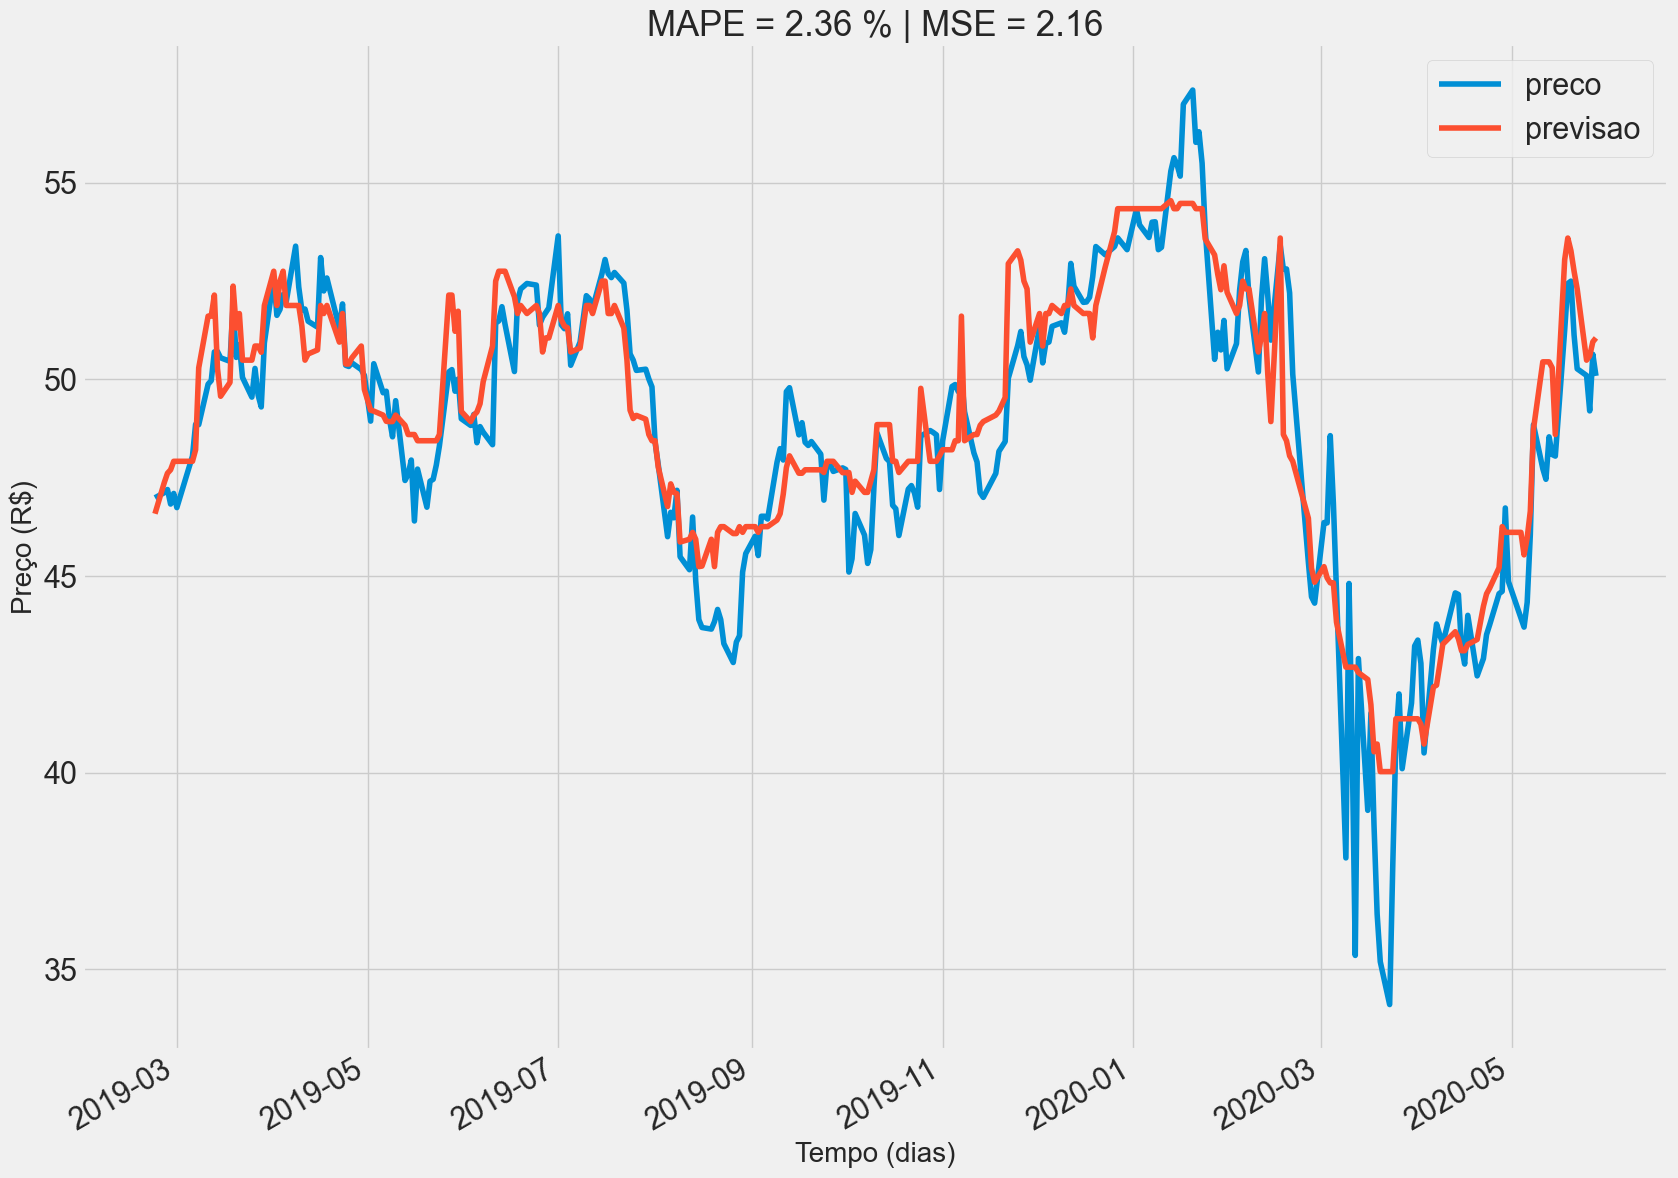

In [35]:
show_result_model(df_test=y_test,
                  y_forecast=y_pred_rf_regressor,
                  model_name='model_rf_regressor',
                  dict_results=dict_results)

---

<br/>

#### **SVM**
- about gamma: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
- Gamma == learning rate

In [36]:
model_svm_regressor = SVR(kernel='rbf', gamma= 0.1)
model_svm_regressor

SVR(gamma=0.1)

In [37]:
model_svm_regressor.fit(X_train, y_train)

SVR(gamma=0.1)

In [38]:
y_pred_svm_regressor = model_svm_regressor.predict(X_test)
y_pred_svm_regressor[:5]

array([45.99084802, 47.55431383, 47.58521492, 47.0727281 , 47.54548022])

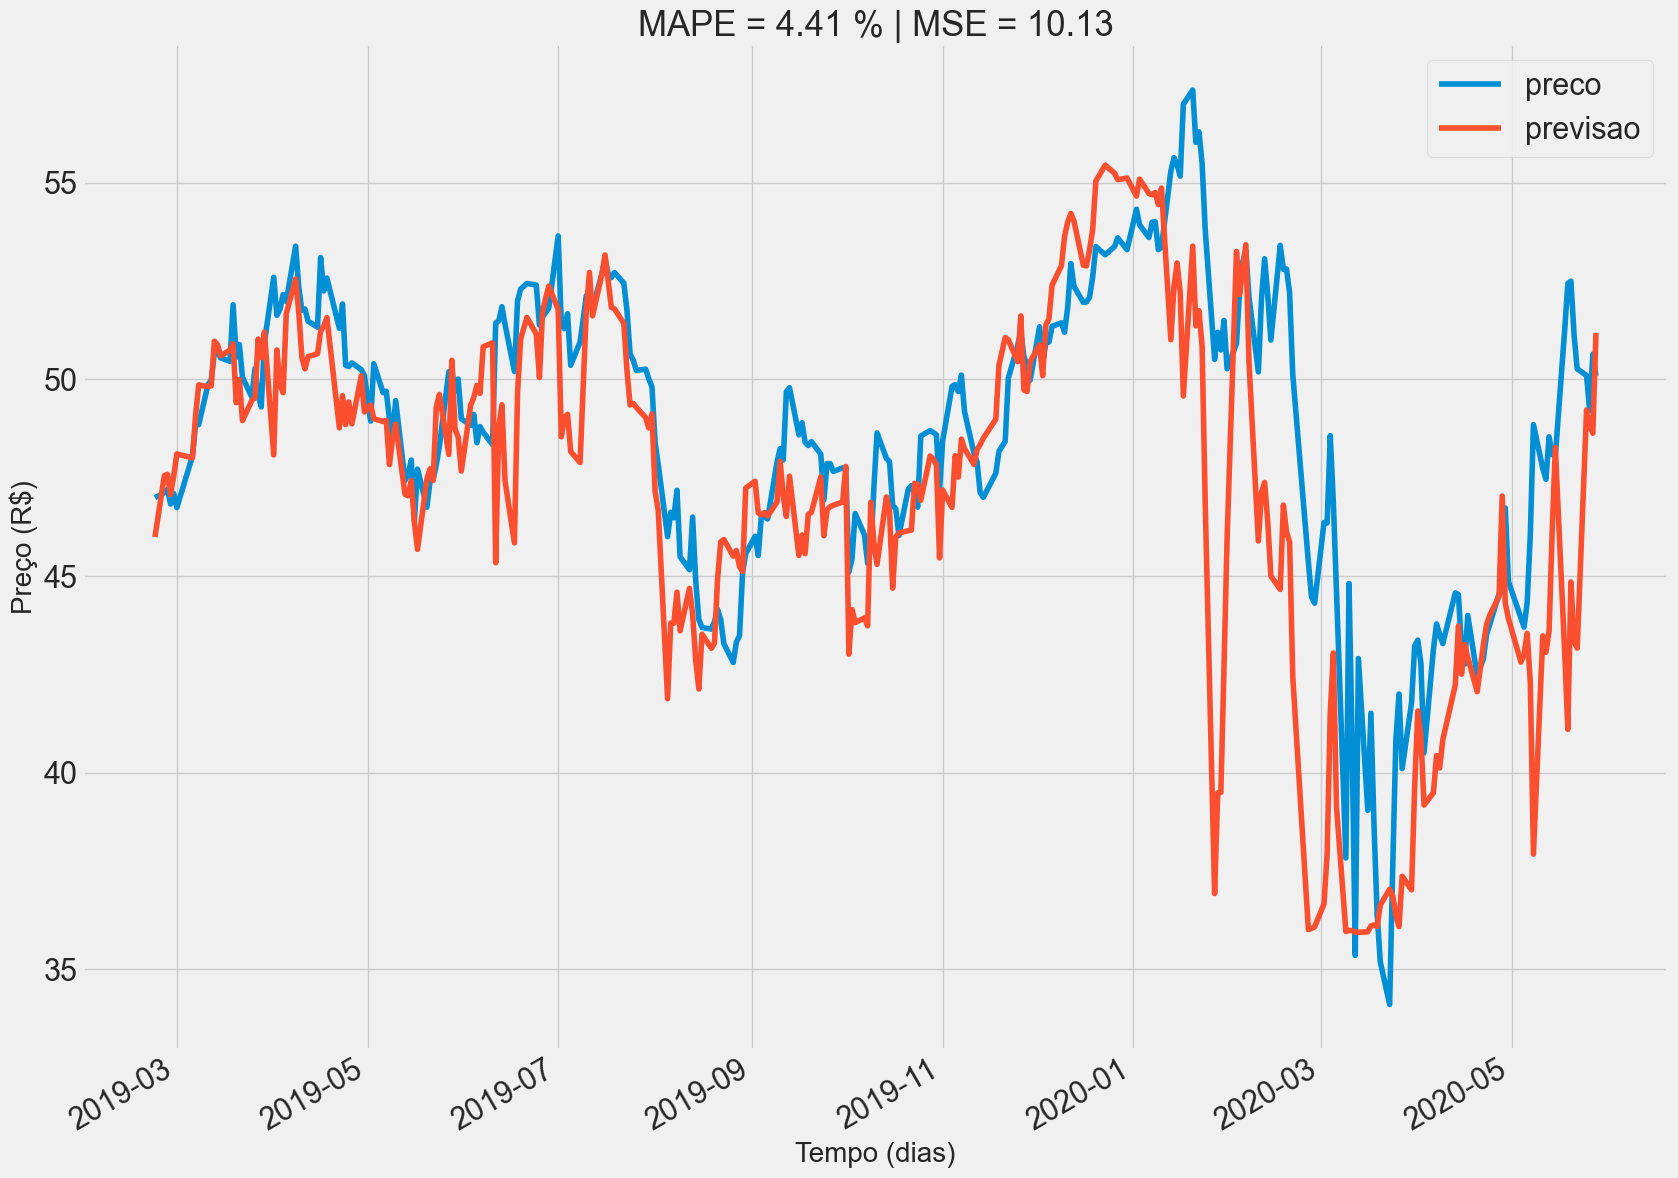

In [39]:
show_result_model(df_test=y_test,
                  y_forecast=y_pred_svm_regressor,
                  model_name='model_svm_regressor',
                  dict_results=dict_results)

#### Zoom

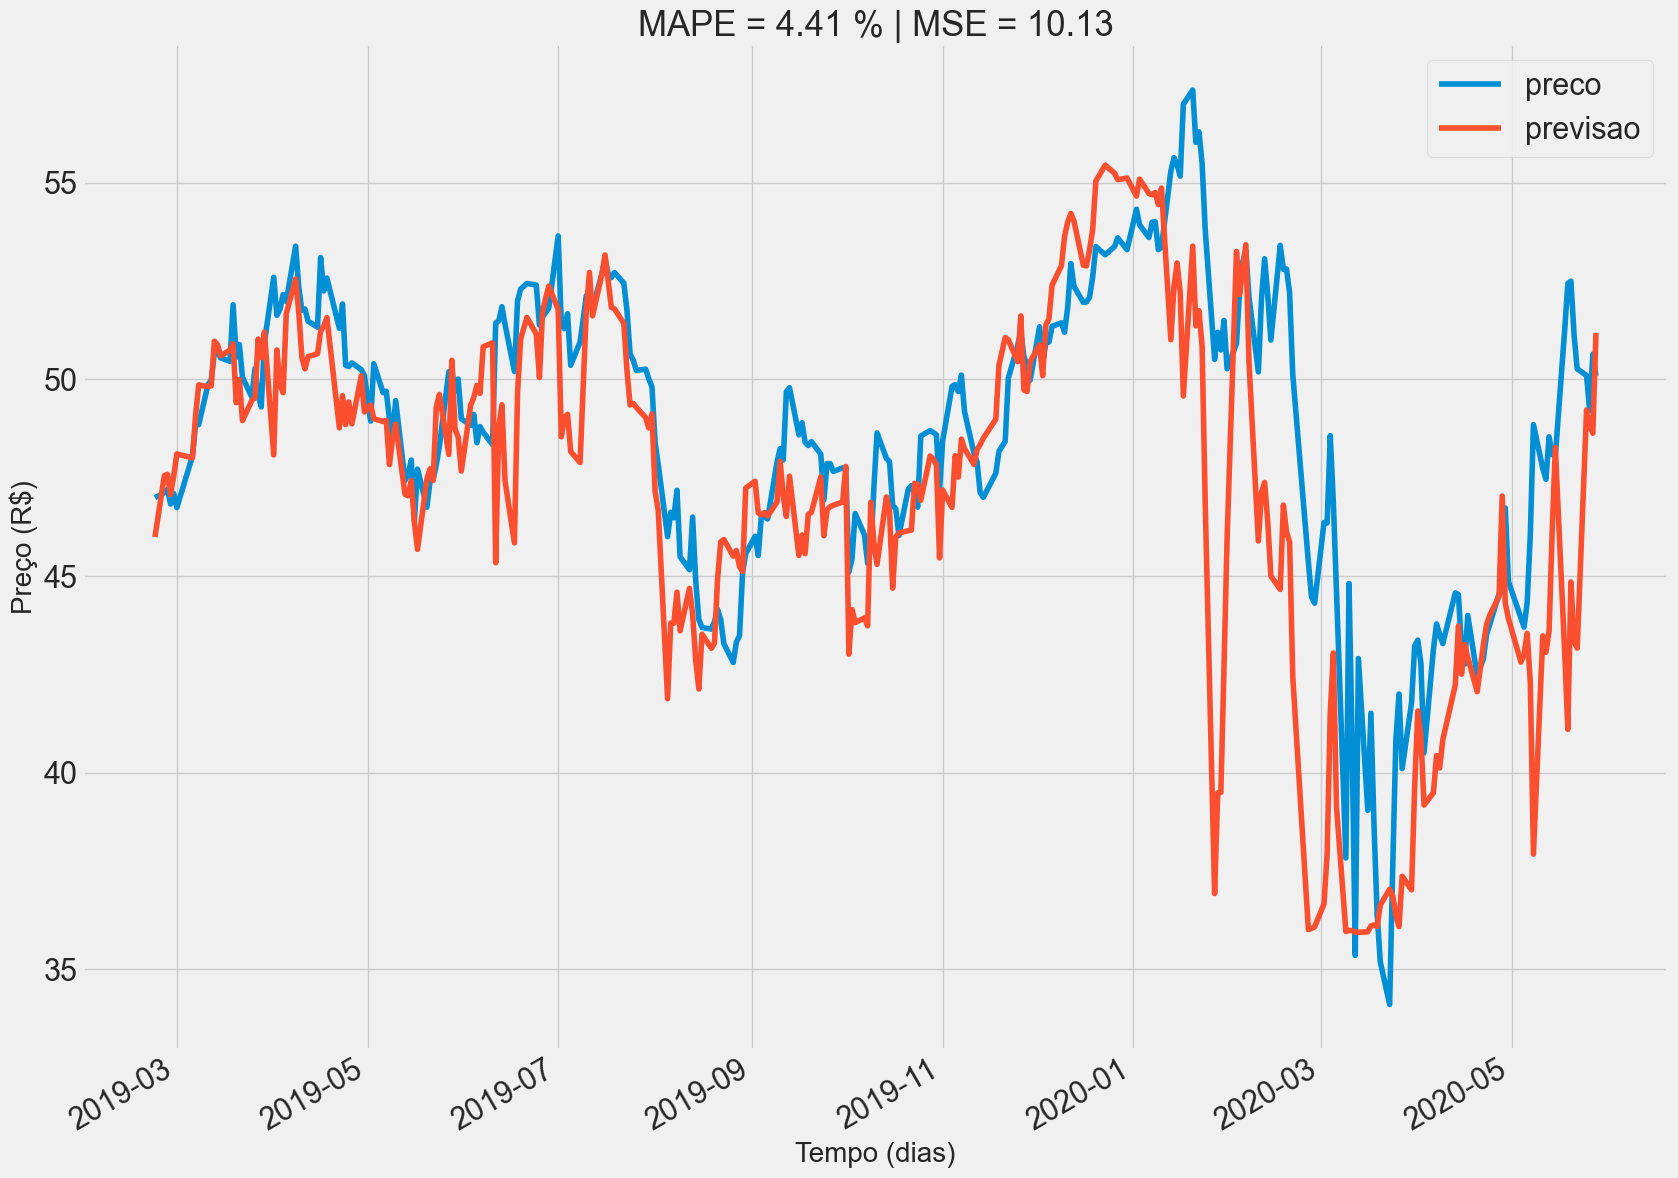

In [40]:
show_result_model(df_test=y_test,
                  y_forecast=y_pred_svm_regressor,
                  model_name='model_svm_regressor',
                  dict_results=dict_results)

---

## **Results**

In [42]:
dict_results

{'model_rf_regressor': [2.3628090200913694, 2.157954747603833],
 'model_svm_regressor': [4.40842194640458, 10.128906074086458]}

---
